# <center>**`Project Details`**</center>

#### **Purpose**:

Our goal is to showcase how to connect LangGraph agent to an MCP server. The MCP server will expose tools for string analysis, while the client (LangGraph agent) will interact with these tools using Python subprocesses.

Here is how the system works:

 - The MCP server exposes tools to perform arithmetic operations (multiplication and subtraction).
 - The Client launches the MCP server and creates a session using standard I/O to enable communication between the LangGraph agent and the MCP tools.
 - The agent loads these tools into its session, intakes the user’s natural language input, and decides whether a tool invocation is needed.
 - If the agent detects a suitable tool is available, it calls the MCP server through the client and retrieves the result.
 - The final response is returned to the user in natural language.

#### **System Architecture**:

 1. **MCP Server**: This component exposes computational tools using FastMCP.
 2. **Custom Client using StdioClient**: We’ll implement a Python client using the StdioClient to interact with the server via subprocesses.
 3. **LangGraph Agent**: We will build a custom ReAct agent using LangGraph. This agent will receive user’s input, decide whether a tool is needed, and if so, it will automatically load the appropriate tool from the MCP tools running in the connected server session.
 4. **Session Communication**: The system uses standard I/O to allow two-way communication between the LangGraph agent and the MCP server.

#### **Constraints**:

 - None


#### **Tools**:

 - Use local **ollama** model

#### **Requirements**:
 - Make it work as expected


***

## <center>**`Implementation`**</center>

### LLM

In [ ]:
#%%writefile src/llm/model_params.py
# model variables
MODEL_URL = "http://ollama:11434"
MODEL_NAME = "llama3.2" # "qwen3" # "mistral" #
MODEL_TEMP = 0.0

In [5]:
#%%writefile src/llm/model_provider.py
from langchain_ollama import ChatOllama
#from src.llm.model_params import MODEL_URL, MODEL_NAME, MODEL_TEMP

def load_model(url:str=MODEL_URL, model_name: str=MODEL_NAME, temperature:float=MODEL_TEMP, **kwargs):
    """Load local ollama model"""
    return ChatOllama(base_url=url, model=model_name, temperature=temperature, **kwargs)

### ReAct agent in LangGraph

#### Agent State

In [ ]:
#%%writefile src/agent/state.py

from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

Writing src/agent/state.py


#### Nodes

In [ ]:
#%%writefile src/agent/nodes.py
#from src.agent.state import AgentState


class ChatNode:
    def __init__(self, llm):
        self.llm = llm

    async def __call__(self, state: AgentState) -> AgentState:
        messages = state['messages']

        response = await self.llm.ainvoke(messages)

        state['messages'].append(response)
        return state

Overwriting src/agent/nodes.py


#### Graph

In [ ]:
#%%writefile src/agent/graph.py

from langgraph.graph import StateGraph, START
from langchain_core.tools import Tool
from typing import Optional, List
from src.llm.model_params import MODEL_URL, MODEL_NAME, MODEL_TEMP
from src.llm.model_provider import load_model
from src.agent.nodes import ChatNode
from src.agent.state import AgentState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display

class AgentGraph:
    def __init__(self, 
                 llm_model_url: str=MODEL_URL,
                 llm_model_name: str=MODEL_NAME,
                 ll_model_temp: float=MODEL_TEMP,
                 tools:Optional[List[Tool]]=[]):
        
        llm = load_model(llm_model_url, llm_model_name, ll_model_temp)
        self.tools = tools
        self.llm = llm.bind_tools(tools) if self.tools else llm
        self.chat_node = ChatNode(self.llm)

    def graph_builder(self):
        graph_builder = StateGraph(AgentState)

        # nodes
        graph_builder.add_node("llm", self.chat_node)
        graph_builder.add_node("tools", ToolNode(tools=self.tools))

        # edges
        graph_builder.add_edge(START, "llm")
        graph_builder.add_conditional_edges("llm", tools_condition)
        graph_builder.add_edge("tools", "llm")

        # compile
        return graph_builder.compile()
    
    @property
    def graph(self):
        if hasattr(self, "_graph"):
            return self._graph
        self._graph = self.graph_builder()
        return self._graph
    
    def display(self):
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def invoke(self, input:str, config: Optional[RunnableConfig]=None):
        return self.graph.invoke(input, config)

    async def ainvoke(self, input:str, config: Optional[RunnableConfig]=None):
        return await self.graph.ainvoke(input, config)

Overwriting src/agent/graph.py


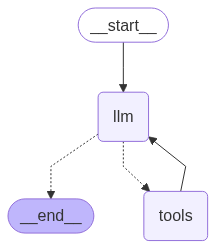

In [12]:
graph = AgentGraph()
graph.display()

#### MCP server

In [ ]:
%%writefile mcp_server.py

from mcp.server.fastmcp import FastMCP

mcp = FastMCP("CalculatorTools")

@mcp.tool()
def multiply_numbers(a: int, b: int) -> int:
    """Returns the product of two integers"""
    return a*b

@mcp.tool()
def subtract_numbers(a: int, b: int) -> int:
    """Returns the difference between two integers"""
    return a-b

if __name__ == "__main__":
    mcp.run(transport="stdio")

Overwriting mcp_server.py


#### MCP client

In [ ]:
#%%writefile mcp_client.py

import asyncio
from src.llm.model_params import MODEL_URL, MODEL_NAME, MODEL_TEMP
from src.agent.graph import AgentGraph
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langchain_core.messages import SystemMessage, HumanMessage

model = ChatOllama(base_url=MODEL_URL, model=MODEL_NAME, temperature=MODEL_TEMP)
TOOL_ONLY_TASKS = {"multiply_numbers", "subtract_numbers"}


async def main():
    server_params = StdioServerParameters(
        command="python",
        args=["mcp_server.py"]
    )

    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read_stream=read, write_stream=write) as session:
            await session.initialize()

            all_tools = await load_mcp_tools(session=session)

            strict_tools = [tool for tool in all_tools if tool.name in TOOL_ONLY_TASKS]

            agent = AgentGraph(tools=strict_tools)

            if strict_tools:
                tool_descriptions = "\n".join(
                    f"- {tool.name}: {tool.description}" for tool in strict_tools
                )

                system_intruction = (
                    "You are a smart assistant. For general conversation and reasoning, you may use your own thinking.\n"
                    "However, for the following operations, you must never calculate by yourself. "
                    "Always use the tools listed below:\n\n"
                    f"{tool_descriptions}\n\n"
                    "if user asks something that requries other tool, use your own thinking and answer it."                    
                )

                system_message = SystemMessage(content=system_intruction)
            else:
                system_message = SystemMessage(content="You are a helpful assistant. Use your own reasoning freely.")

            print("Calculator Assistant is ready. Type 'exit' to quit.\n")

            while True:
                user_input = input("You: ").strip()
                if user_input.lower() in {"exit", "quit"}:
                    print("Exiting...")
                    break

                input_messages = [system_message, HumanMessage(content=user_input)]

                try:
                    result = await agent.ainvoke({"messages": input_messages})
                    for m in result["messages"]:
                        m.pretty_print()
                except Exception as e:
                    print("Error:", e)

if __name__ == "__main__":
    asyncio.run(main())

Overwriting mcp_client.py
